# Recommendation Systems Assignment

### MIE 1513 UofT

### Imports

In [ ]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget
np.seterr(invalid='ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## Support functions and variables

In [ ]:
wget.download("https://github.com/MIE1513HS-2022/course-datasets/raw/main/ml-100k.zip", "ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [ ]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [ ]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [ ]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [ ]:
rating_df_train = getData(MOVIELENS_DIR, 'u1.base')
rating_df_test = getData(MOVIELENS_DIR, 'u1.test')

In [ ]:
rating_df_train.head()

,userID,itemID,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
print("Number of users in rating df:", len(rating_df.userID.unique()))
print("Number of items in rating df:", len(rating_df.itemID.unique()))
print("Number of users in train df:", len(rating_df_train.userID.unique()))
print("Number of items in train df:", len(rating_df_train.itemID.unique()))
print("Number of users in test df:", len(rating_df_test.userID.unique()))
print("Number of items in test df:", len(rating_df_test.itemID.unique()))

Number of users in rating df: 943
Number of items in rating df: 1682
Number of users in train df: 943
Number of items in train df: 1650
Number of users in test df: 459
Number of items in test df: 1410


## Q1

### (a)

In [ ]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########

    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating

    ###########         end         ###########
    return matrix

### (b)

In [ ]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # select the row for user
                # what's the shape of userVector
                userVector = train_matrix[user, :]
                
                # Extract the items the user already rated
                ratedItems = userVector[userVector.nonzero()]
                
                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg
                
            # # report progress every 100 users
            # if (user % 100 == 0 and item == 1):
            #     print ("calculated %d users" % (user,))
      
        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros

        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]
                
            # # report progress every 100 users
            # if (user % 100 == 0 and item == 1):
            #     print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        self.__model = None

In [ ]:
popularity_recsys = BaseLineRecSys('popularity')

In [ ]:
popularity_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [ ]:
x = popularity_recsys.getModel()

In [ ]:
np.all(x<=1)

True

In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
popularity_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:06, 3053.32it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


In [ ]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [ ]:
average_user_rating_recsys.predict_all(rating_df_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [ ]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.68148148, 3.68148148,
        3.68148148],
       [0.        , 3.8       , 3.8       , ..., 3.8       , 3.8       ,
        3.8       ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [ ]:
average_user_rating_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:05, 3481.18it/s]


,userID,itemID,rating,timestamp,useraverage
0,1,6,5,887431973,3.681481
1,1,10,3,875693118,3.681481
2,1,12,5,878542960,3.681481
3,1,14,5,874965706,3.681481
4,1,17,3,875073198,3.681481


## Q2

### (a)

In [ ]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        dist_mat = pairwise_distances(matrix, metric='euclidean')
        #normalize the distance between 0 to 1, larger distance, smaller similarity
        distance_norm = (dist_mat-np.min(dist_mat))/(np.max(dist_mat)-np.min(dist_mat))
        similarity_matrix = 1 - distance_norm

        
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########


        dist_mat = pairwise_distances(matrix, metric='manhattan')
        #normalize the distance between 0 to 1, larger distance, smaller similarity
        distance_norm = (dist_mat-np.min(dist_mat))/(np.max(dist_mat)-np.min(dist_mat))
        similarity_matrix = 1 - distance_norm
    
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.__model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        # Initialize the predicted rating matrix with zeros
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        
        if self.base == 'user':
            ########### your code goes here ###########

            #UxU matrix
            uu_similarity = self.method(train_matrix)

            #apply KNN and only keep top 5
            k = 5
            sim = uu_similarity.copy()
            m,n = sim.shape
            for i in range(m):
            # only keep the k largest number (set other similarity to 0)
                sim[i, sim[i].argsort()[:-k]] = 0

            uu_similarity = sim
           
           # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
    
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)

            self.__model = predictionMatrix


            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########


            #IxI matrix
            ii_similarity = self.method(np.transpose(train_matrix))
            #apply KNN
            k = 5
            sim = ii_similarity.copy()
            m,n = sim.shape
            for i in range(m):
            # only keep the k largest number 
                sim[i, sim[i].argsort()[:-k]] = 0

            ii_similarity = sim
           
           # UxI: UxI mul IxI
            normalizer = np.matmul(temp_matrix, ii_similarity)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            
            # UxI: UxI mul IxI
            predictionMatrix = np.matmul(train_matrix, ii_similarity)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)

            self.__model = predictionMatrix


            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        self.__model = None

In [ ]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
SimBasedRecSys.euclidean(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
SimBasedRecSys.somethingelse(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

The cosine similarity works better. The cosine similarity captures the angles between documents but not the magnitude; However, the Euclidean distance focus on the magnitude.

The cosine similarity works better even if the two similar documents are far apart by the Euclidean distance (due to the size of the document), chances are they may still be oriented closer together.

### (b)

I chose `manhattan`.`Manhattan`measures the distance between two points by summing the absolute differences between their coordinates. 

In the context of collaborative filtering, Manhattan distance can be more suitable for sparse or high-dimensional data because it does not penalize missing values or outliers as much as Euclidean distance.

## Q3

### (a)

In [ ]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [ ]:
user_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [ ]:
user_cosine_recsys.getModel()

array([[4.69560462, 3.2763019 , 4.        , ..., 0.        , 0.        ,
        0.        ],
       [4.19276348, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [4.17890236, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.67140893, 3.78344841, 3.95601481, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
user_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:06, 3231.57it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,6,5,887431973,0.000000
1,1,10,3,875693118,4.000000
2,1,12,5,878542960,4.738922
3,1,14,5,874965706,3.969857
4,1,17,3,875073198,4.000000


test item cosine

In [ ]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [ ]:
item_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [ ]:
item_cosine_recsys.getModel()

array([[4.41340712, 3.        , 4.        , ..., 0.        , 0.        ,
        0.        ],
       [4.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [4.70654072, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [4.51825908, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [4.        , 4.18429549, 3.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
item_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:05, 3433.76it/s]


,userID,itemID,rating,timestamp,item-cosine
0,1,6,5,887431973,0.000000
1,1,10,3,875693118,0.000000
2,1,12,5,878542960,2.929275
3,1,14,5,874965706,3.972336
4,1,17,3,875073198,0.000000


### (b)

In [ ]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
            'RPrecision': self.rprecision
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    def rprecision(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet = self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRPs = 0
        countRPs = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID, :]


            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID, :]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            topK = nlargest(len(userTestVector), range(len(userVector)), userVector.take)
            # Calculate recall
            rp = float(len([item for item in topK if item in userTestVector])) / len(userTestVector)

            # Update sum and count
            sumRPs += rp
            countRPs += 1

        # Return average R@k
        return float(sumRPs) / countRPs

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [ ]:
# How to use CrossValidation Class?

In [ ]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       item_cosine_recsys]

In [ ]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
cv_patk = CrossValidation('RMSE')

In [ ]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm popularity


20000it [00:05, 3727.75it/s]
20000it [00:05, 3480.70it/s]
20000it [00:06, 3289.54it/s]
20000it [00:04, 4161.85it/s]
20000it [00:07, 2763.40it/s]


Processing algorithm useraverage


20000it [00:04, 4166.46it/s]
20000it [00:05, 3851.23it/s]
20000it [00:06, 3111.33it/s]
20000it [00:05, 3508.45it/s]
20000it [00:06, 3218.28it/s]


Processing algorithm user-cosine


20000it [00:05, 3672.89it/s]
20000it [00:04, 4033.99it/s]
20000it [00:09, 2045.74it/s]
20000it [00:07, 2812.70it/s]
20000it [00:05, 3615.70it/s]


Processing algorithm item-cosine


20000it [00:06, 2935.28it/s]
20000it [00:05, 3461.22it/s]
20000it [00:06, 3019.50it/s]
20000it [00:07, 2720.56it/s]
20000it [00:05, 3920.47it/s]


{'popularity': [[3.177941281084362,
   3.1750480150769977,
   3.147474655005899,
   3.146164503024159,
   3.1488360007536382],
  3.1590928909890112,
  3.139292746995387,
  3.1788930349826354],
 'useraverage': [[1.0629951276561334,
   1.0467467492319966,
   1.0328964562995389,
   1.0366575971298078,
   1.0392923504800367],
  1.0437176561595025,
  1.0289303496379316,
  1.0585049626810734],
 'user-cosine': [[1.9137357434827604,
   1.926719724781564,
   1.9593689335480144,
   1.9090939877477815,
   1.9504106221643167],
  1.9318658023448876,
  1.9042819267220346,
  1.9594496779677406],
 'item-cosine': [[2.7089811056959183,
   2.603975146388891,
   2.5956473873274017,
   2.582843725259232,
   2.671290135849579],
  2.632547500104205,
  2.5645627086119083,
  2.7005322915965015]}

1. For the user-user based collaborative filtering for cosine similarity, we have:

(1) average RMSE : 1.932

(2) confidence intervals: [1.904, 1.959]

2. For item-item based collaborative filtering for cosine similarity, we have: 

(1) average RMSE score: 2.633

(2) confidence intervals: [2.565, 2.701]

3. The user-user based collaborative filtering performed better than the item-item based collaborative filtering. This may due to the cold start problem in the dataset. When a new user joins the system, there is no information available about their preferences. In such cases, user-user collaborative filtering can use the preferences of similar users to generate recommendations for the new user.

Moreover, user-based collaborative filtering perform better for the dataset with items that are popular among users who have similar preferences.

In [ ]:
matrix = dataPreprocessor(rating_df_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [ ]:
# compute the average number of ratings per user
num_rating_per_user = np.sum(matrix != 0, axis=1)
avg_rating_per_user = np.mean(num_rating_per_user)


# compute the average number of ratings per item
num_rating_per_item = np.sum(matrix != 0, axis=0)
avg_rating_per_item = np.mean(num_rating_per_item)

num_user_with_no_rating = np.sum(np.sum(matrix, axis=1) == 0)
num_item_with_no_rating = np.sum(np.sum(matrix, axis=0) == 0)

print("Average number of ratings per user is", round(avg_rating_per_user,3))
print("Average number of ratings per item is", round(avg_rating_per_item,3))
print("Number of items not rated by any user is", num_item_with_no_rating)
print("Number of users who have not rated any item is", num_user_with_no_rating)

Average number of ratings per user is 84.836
Average number of ratings per item is 47.562
Number of items not rated by any user is 32
Number of users who have not rated any item is 0


## Q4

### (a)

In [ ]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
cv_patk = CrossValidation('P@K')

In [ ]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm popularity


20000it [00:05, 3675.64it/s]
20000it [00:04, 4006.12it/s]
20000it [00:04, 4016.01it/s]
20000it [00:05, 3806.21it/s]
20000it [00:05, 3971.73it/s]


Processing algorithm useraverage


20000it [00:05, 3993.72it/s]
20000it [00:06, 3235.74it/s]
20000it [00:05, 3391.39it/s]
20000it [00:04, 4093.09it/s]
20000it [00:05, 3775.44it/s]


Processing algorithm user-cosine


20000it [00:05, 3389.65it/s]
20000it [00:05, 3994.19it/s]
20000it [00:04, 4020.81it/s]
20000it [00:05, 3383.30it/s]
20000it [00:05, 3951.80it/s]


Processing algorithm item-cosine


20000it [00:05, 3575.12it/s]
20000it [00:05, 3480.82it/s]
20000it [00:05, 3965.73it/s]
20000it [00:05, 3744.94it/s]
20000it [00:05, 3421.56it/s]


{'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459],
 'user-cosine': [[0.32704135737009626,
   0.4464475079533413,
   0.5378579003181346,
   0.5656415694591748,
   0.5565217391304368],
  0.48670201484623676,
  0.3612461335350114,
  0.6121578961574621],
 'item-cosine': [[0.32449628844114553,
   0.43669141039236614,
   0.5162248144220587,
   0.5372216330858977,
   0.5132555673382835],
  0.4655779427359503,
  0.35678248020985814,
  0.5743734052620425]}

In [ ]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
cv_patk = CrossValidation('RPrecision')

In [ ]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm popularity


20000it [00:05, 3972.73it/s]
20000it [00:04, 4070.27it/s]
20000it [00:04, 4098.31it/s]
20000it [00:05, 3727.94it/s]
20000it [00:05, 3457.54it/s]


Processing algorithm useraverage


20000it [00:05, 3601.28it/s]
20000it [00:04, 4020.82it/s]
20000it [00:05, 3587.24it/s]
20000it [00:05, 3402.57it/s]
20000it [00:04, 4039.04it/s]


Processing algorithm user-cosine


20000it [00:05, 3806.83it/s]
20000it [00:05, 3711.60it/s]
20000it [00:05, 3974.10it/s]
20000it [00:05, 3401.80it/s]
20000it [00:05, 3975.73it/s]


Processing algorithm item-cosine


20000it [00:05, 3593.10it/s]
20000it [00:05, 3763.30it/s]
20000it [00:05, 3906.69it/s]
20000it [00:06, 3330.43it/s]
20000it [00:05, 3882.35it/s]


{'popularity': [[0.7177873723889607,
   0.7070154178036713,
   0.7125502990452603,
   0.720853383606364,
   0.7301257801821563],
  0.7176664506052826,
  0.7068236314882174,
  0.7285092697223478],
 'useraverage': [[0.6403680886295169,
   0.6452698039088018,
   0.6415499021363597,
   0.6509000064353649,
   0.6505646590135201],
  0.6457304920247127,
  0.6396305850946756,
  0.6518303989547497],
 'user-cosine': [[0.6098268451638489,
   0.6113631904914669,
   0.6083590925255951,
   0.6268518235877789,
   0.614975050159531],
  0.6142752003856442,
  0.6050264862715916,
  0.6235239144996968],
 'item-cosine': [[0.4731942363143127,
   0.5145729458368432,
   0.498679079650449,
   0.5180800601721502,
   0.5037312711512664],
  0.5016515186250043,
  0.4796155860584336,
  0.5236874511915751]}






> RMSE:

a. popularity: 3.159

b. useraverage: 1.044

c. user-cosine: 1.932

d. item-cosine: 2.633

> P@k:

a.popularity:  0.551

b.useraverage: 0.474

c.user-cosine: 0.487

d.item-cosine: 0.466

> R-Precision:

a.popularity:  0.718

b.useraverage: 0.646

c.user-cosine: 0.614

d.item-cosine: 0.502


### (b)

RMSE cannot be used to evaluate the popularity based recommendation systems. 

The popularity based recommendation systems check about movies which are most popular (or in trend) among the users and directly recommend those, and make predictions to the score; In contrast, RMSE calculates the rooted mean squared error between the predicted rating and the true rating.

### (c)

For RMSE, the best algorithm is user average, which has the lowest RMSE.

Reason:RMSE is a metric measures the average difference between the predicted and actual ratings. In a user average recommendation system, the predicted rating for an item is the average rating the user has rated in the past and make predictions based on the preference of users. This approach tends to work well for RMSE because it is a measure of the difference between the predicted and actual ratings. Users in the dataset has a consistent rating behavior across items.

For P@K and R-Precision, the best algorithm is popularity. The P@K and R-Precision for popularity is the highest among these algorithms.
Popularity recommendation systems are more likely to include items that are highly rated by many users. P@K and R-Precision measure the effectiveness of a recommendation system whether it includes the items that a user has actually rated highly. 

### (d)

Good performance on RMSE does not imply good performance on ranking metrics. 

Reason: RMSE scores focus on the prediction of ratings and place equal emphasis on high and low ratings and does not measure the quality of ranking of the items. Lower RMSE scores indcates that the average difference between the predicted and actual ratings is small.

The ranking metrics only focus on several most important/popular items with the largest rating scores. Good performance of RMSE does not always lead to good ranking metrics.

## Q5

### (a)

In [ ]:
train_matrix = dataPreprocessor(rating_df_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

# Initialize the predicted rating matrix with zeros
temp_matrix = np.zeros(train_matrix.shape)
temp_matrix[train_matrix.nonzero()] = 1
#IxI matrix
ii_similarity = 1 - pairwise_distances(np.transpose(train_matrix), metric='cosine')

In [ ]:
movies_of_interest = [100-1, 1000-1, 1500-1]

In [ ]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
for row in movies_of_interest:
      # select the row corresponding to the given movie_id
      selected_row = moviesDF[moviesDF["movieID"] == row+1]

      # extract the movie_title and release_date from the selected row
      title = selected_row["movieTitle"].values[0]
      release_date = selected_row["releaseDate"].values[0]
      print(f"Recommend based on Title:'{title}' Release date: '{release_date}'.")

      sorted_indices = np.argsort(ii_similarity[row])[::-1] #sort the row in desc
      top_5_movie_id = sorted_indices[1:6]+1 # get the first 5 indices

      for movie_id in top_5_movie_id:
      # select the row corresponding to the given movie_id
        selected_row = moviesDF[moviesDF["movieID"] == movie_id]

       # extract the movie_title and release_date from the selected row
        title = selected_row["movieTitle"].values[0]
        release_date = selected_row["releaseDate"].values[0]

      # display the movie_title and release_date
        print(f"Title:'{title}' Release date: '{release_date}'.")

Recommend based on Title:'Fargo (1996)' Release date: '14-Feb-1997'.
Title:'Star Wars (1977)' Release date: '01-Jan-1977'.
Title:'Twelve Monkeys (1995)' Release date: '01-Jan-1995'.
Title:'Godfather, The (1972)' Release date: '01-Jan-1972'.
Title:'Jerry Maguire (1996)' Release date: '13-Dec-1996'.
Title:'Toy Story (1995)' Release date: '01-Jan-1995'.
Recommend based on Title:'Lightning Jack (1994)' Release date: '01-Jan-1994'.
Title:'Destiny Turns on the Radio (1995)' Release date: '01-Jan-1995'.
Title:'Clean Slate (1994)' Release date: '01-Jan-1994'.
Title:'Being Human (1993)' Release date: '01-Jan-1993'.
Title:'Cops and Robbersons (1994)' Release date: '01-Jan-1994'.
Title:'Scout, The (1994)' Release date: '01-Jan-1994'.
Recommend based on Title:'Santa with Muscles (1996)' Release date: '08-Nov-1996'.
Title:'Lost Highway (1997)' Release date: '21-Feb-1997'.
Title:'Patton (1970)' Release date: '01-Jan-1970'.
Title:'Cool Hand Luke (1967)' Release date: '01-Jan-1967'.
Title:'Young Guns 

I choose the movie with ID = 100, 1000 and 1500.

### (b)

For the move "Fargo", is a crime drama film, while Star Wars is a space opera that takes place in a fictional galaxy. Twelve Monkeys is a sci-fi thriller that involves time travel, while The Godfather is a classic crime drama about a mafia family. Toy Story is an animated adventure-comedy film, while Jerry Maguire is a romantic comedy-drama that revolves around a sports agent, and it range from heartbreaking to inspiring to laugh-out-loud funny. All of these films are thrilling or with fluctuations in plot, users who like thrilling films .

The movie Santa with Muscles, a 1996 comedy film starring Hulk Hogan, does not have any direct similarities with the movies Lost Highway, Patton, Cool Hand Luke, Young Guns, and Cop Land.
However, they all deal with issues of identity, power, and rebellion in some form. They explore the complex relationships between individuals and society, and the struggles that people face when trying to assert their independence and challenge established norms and authority figures.

Moreover, the similarity is determined indirectly by users who rated both items, so for each categories, users rated one of these films for one are more likely to rate others.

## Q6

### (a)

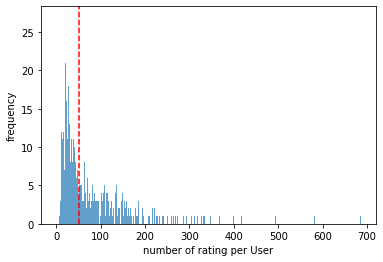

In [ ]:
# Calculate the number of ratings per user
num_ratings_per_user = np.sum(train_matrix != 0, axis=1)

# Set the threshold τ to divide users into two groups
thr = 50

# Define the bin edges for the histogram with thinner bins
bin_edges = np.arange(0, np.max(num_ratings_per_user) + 2) - 0.5

# Make a histogram of the number of ratings per user with thinner bins
plt.hist(num_ratings_per_user, bins=bin_edges, alpha=0.7)

# Add a vertical dashed line at the chosen threshold τ
plt.axvline(x=thr, color='r', linestyle='--')

# Set the x-axis and y-axis labels
plt.xlabel('number of rating per User')
plt.ylabel('frequency')

# Show the plot
plt.show()


In [ ]:
# Get the count of ratings per user
count_user = rating_df_train['userID'].value_counts()

In [ ]:
rating_filtered_above = rating_df_train[rating_df_train['userID'].isin(count_user.index[count_user > 50])]
rating_filtered_below = rating_df_train[rating_df_train['userID'].isin(count_user.index[count_user < 50])]

In [ ]:
user_cos_recsys_above = SimBasedRecSys('user','cosine')
user_cos_recsys_below = SimBasedRecSys('user','cosine')

In [ ]:
item_cos_recsys_above = SimBasedRecSys('item','cosine')
item_cos_recsys_below = SimBasedRecSys('item','cosine')

In [ ]:
user_cos_recsys_above.predict_all(rating_filtered_above,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
user_cos_recsys_below.predict_all(rating_filtered_below,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [ ]:
item_cos_recsys_above.predict_all(rating_filtered_above,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
item_cos_recsys_below.predict_all(rating_filtered_below,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [ ]:
def get_rmse(pred, test):
    predlist = pred[test.nonzero()].flatten() 
    testlist = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predlist, testlist))

In [ ]:
print("Above threshold τ of rated items with user-based", "RMSE: ",get_rmse(user_cos_recsys_above.getModel(), dataPreprocessor(rating_filtered_above,len(rating_df.userID.unique()), len(rating_df.itemID.unique()))))

print("Above threshold τ of rated items with item-based", "RMSE: ",get_rmse(item_cos_recsys_above.getModel(), dataPreprocessor(rating_filtered_above,len(rating_df.userID.unique()), len(rating_df.itemID.unique()))))

print("Below threshold τ of rated items with user-based", "RMSE: ",get_rmse(user_cos_recsys_below.getModel(), dataPreprocessor(rating_filtered_below,len(rating_df.userID.unique()), len(rating_df.itemID.unique()))))

print("Below threshold τ of rated items with item-based", "RMSE: ",get_rmse(item_cos_recsys_below.getModel(), dataPreprocessor(rating_filtered_below,len(rating_df.userID.unique()), len(rating_df.itemID.unique()))))

Above threshold τ of rated items with user-based RMSE:  0.5225512390941993
Above threshold τ of rated items with item-based RMSE:  0.4224682875606723
Below threshold τ of rated items with user-based RMSE:  0.4036308432621941
Below threshold τ of rated items with item-based RMSE:  0.3889297554697177


I chose τ  = 50

For both item-item and user-user collaborative filterings, we have users below threshold τ  of rated items has lower RMSE, which indicates has better performance. In contrast, for users above threshold, the RMSE for both item-item and user-user collaborative filterins are relatively large

Reason: This difference may be explained by the difference in users' preferences. 

Users with less ratings may has more specific preference and specific tastes, which are relatively easy to be predicted by other users with the same tastes. Their tastes for movies may only focus on small groups of movies and may not have that much variation, which makes it easier to be predicted using item-item as well. In contrast, users who rate a lot movies may have more complecated tastes that are harder to be predicted.

# Validation

In [ ]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [ ]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [ ]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [ ]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validatePopularityRecSys()

### User Average Based Recommendation

In [ ]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateUserAverRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [ ]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [ ]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [ ]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [ ]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [ ]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateUUSimBasedRecSys()

### Item-Item Similarity Based Recommendation System

In [ ]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        item_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        item_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = item_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateIISimBasedRecSys()